In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

In [2]:
df_sales_train = pd.read_hdf("../input/sales_train.h5")
df_sales_test = pd.read_hdf("../input/sales_test.h5")

In [3]:
df_sales_train["date"] = pd.to_datetime(df_sales_train["date"], dayfirst=True)
df_sales_test["date"] = pd.to_datetime(df_sales_test["date"], dayfirst=True)

In [4]:
df_sales_train['week'] = df_sales_train['date'].dt.isocalendar().week
df_sales_test['week'] = df_sales_test['date'].dt.isocalendar().week

df_sales_train['month'] = df_sales_train['date'].dt.month
df_sales_test['month'] = df_sales_test['date'].dt.month

In [5]:
df_sales_train.sample(3)

,id,weekly_sales,store,dept,date,is_holiday,week,month
413011,413011,29017.509766,32,93,2010-06-25,False,25,6
338671,338671,23923.410156,39,97,2010-06-04,False,22,6
336925,336925,77685.593750,11,72,2011-10-28,False,43,10


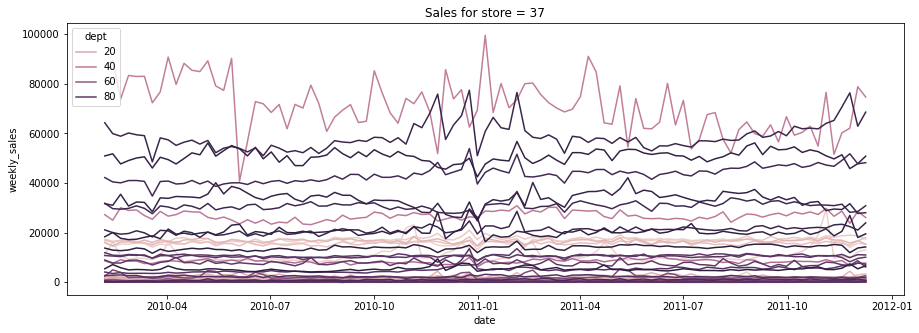

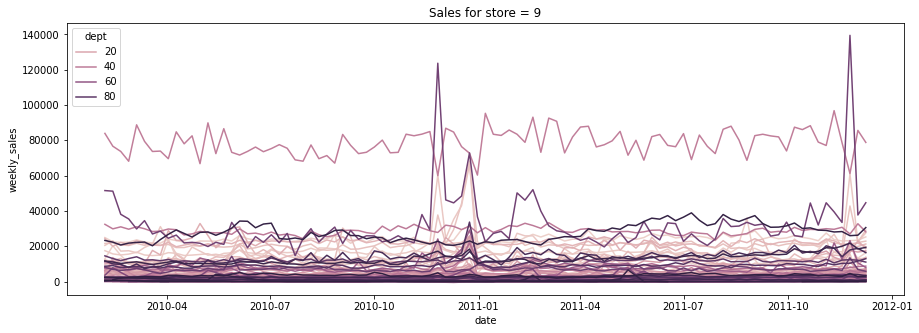

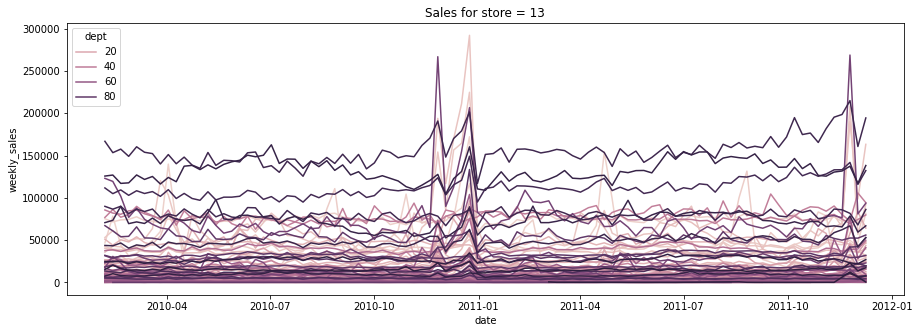

In [6]:
for i in range(3):
    random_store = df_sales_train.store.sample().values[0]
    plt.title("Sales for store = {}".format(random_store))
    sns.lineplot(x='date', y='weekly_sales', hue="dept", data=df_sales_train[df_sales_train.store == random_store]);
    plt.show()

### Dołączenie danych o średniej sprzedaży

### Dodatkowa charakterystyka sklepu
Średnioroczna sprzedaż per sklep

In [7]:
df_store_agg = df_sales_train.groupby(["store"])["weekly_sales"].agg(["mean", "std", "median", "size"]).reset_index()
df_store_agg.head()

,store,mean,std,median,size
0,1,21374.376953,27255.341955,10253.300781,6950
1,2,26863.833984,32835.166002,14412.969727,6937
2,3,6226.871582,15078.119041,2693.699951,6117
3,4,28493.947266,33695.399996,14835.009766,6960
4,5,4936.753418,7837.545720,2524.500000,6101


In [8]:
df_store_agg.rename(columns={'mean': 'store_mean', 'std':'store_std', 'median':'store_median', 'size':'store_agg_size'}, inplace=True)

In [9]:
df_sales_train = pd.merge(df_sales_train, df_store_agg, how='left', on='store')
df_sales_test = pd.merge(df_sales_test, df_store_agg, how='left', on='store') 

In [10]:
df_sales_train.sample(3)

,id,weekly_sales,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,store_agg_size
221020,326884,16911.480469,38,40,2010-02-26,False,8,2,7191.760254,11712.813002,767.640015,4917
203283,300656,1134.000000,4,36,2010-10-15,False,41,10,28493.947266,33695.399996,14835.009766,6960
253381,374526,51092.480469,10,10,2011-09-02,False,35,9,26363.626953,32963.525168,13780.839844,7033


Średnia sprzedaż w departamencie

In [11]:
df_dept_agg = df_sales_train.groupby(['store', 'dept'])["weekly_sales"].agg(["mean", "std", "median", "size"]).reset_index()
df_dept_agg.head()

,store,dept,mean,std,median,size
0,1,1,22494.710938,9784.865055,18820.289062,97
1,1,2,45666.632812,3038.616183,45222.300781,97
2,1,3,12785.541992,8479.493226,10136.780273,97
3,1,4,36428.882812,2818.775517,36174.429688,97
4,1,5,24401.593750,12340.451510,21183.419922,97


In [12]:
df_dept_agg.rename(columns={'mean': 'dept_mean', 'std':'dept_std', 'median':'dept_median', 'size':'dept_agg_size'}, inplace=True)

In [13]:
df_sales_train = pd.merge(df_sales_train, df_dept_agg, how='left', on=['store', 'dept']).fillna(-1)
df_sales_test = pd.merge(df_sales_test, df_dept_agg, how='left', on=['store', 'dept']).fillna(-1)

In [14]:
df_sales_test.sample(3)

,id,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,store_agg_size,dept_mean,dept_std,dept_median,dept_agg_size
129228,399375,45,25,2012-06-22,False,25,6,11676.592773,14139.924920,6029.915039,6526,8500.298828,1645.946652,8318.750000,97.0
48771,149988,20,93,2012-10-26,False,43,10,29361.169922,35418.463571,16461.980469,6921,51698.015625,7433.927916,51764.328125,97.0
17938,55165,15,12,2011-12-23,False,51,12,9183.611328,11850.500597,4894.140137,6713,3667.588135,902.682700,3822.949951,97.0


---

### Features - z dodatkowego pliku

In [15]:
df_features_train = pd.read_hdf("../input/features_train.h5")
df_features_test = pd.read_hdf("../input/features_test.h5")
df_features_train["date"] = pd.to_datetime(df_features_train["date"], dayfirst=True)
df_features_test["date"] = pd.to_datetime(df_features_test["date"], dayfirst=True)

In [16]:
print(df_features_train.shape, df_features_test.shape)

(4365, 12) (3825, 3)


In [17]:
df_features_train['week'] = df_features_train['date'].dt.isocalendar().week
df_features_test['week'] = df_features_test['date'].dt.isocalendar().week

In [18]:
df_features_train.sample(3)

,store,date,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,is_holiday,week
2799,16,2011-06-03,12.265625,3.763672,NaN,NaN,NaN,NaN,NaN,192.8750,6.339844,False,22
562,4,2010-05-28,19.843750,2.755859,NaN,NaN,NaN,NaN,NaN,126.1875,7.894531,False,21
6815,38,2011-08-26,34.781250,3.740234,NaN,NaN,NaN,NaN,NaN,129.2500,13.500000,False,34


In [19]:
df_features_test.sample(3)

,store,date,is_holiday,week
5244,29,2012-12-07,False,49
6847,38,2012-04-06,False,14
5982,33,2013-02-15,False,7


In [20]:
print('Train min:', df_features_train['date'].min())
print('Train max:', df_features_train['date'].max())
print()
print('Test min:', df_features_test['date'].min())
print('Test max:', df_features_test['date'].max())

Train min: 2010-02-05 00:00:00
Train max: 2011-12-09 00:00:00

Test min: 2011-12-16 00:00:00
Test max: 2013-07-26 00:00:00


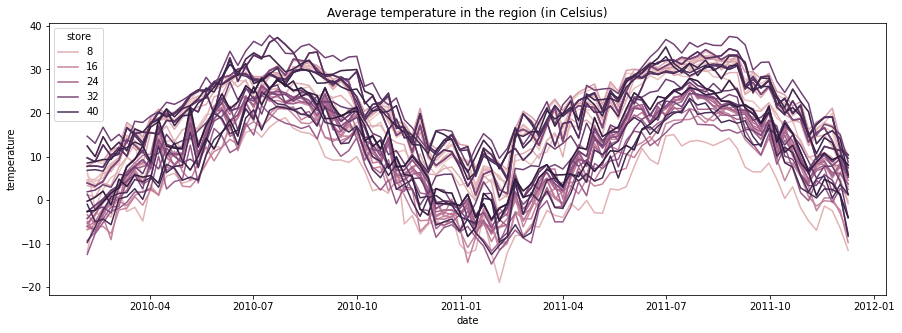

In [21]:
plt.title("Average temperature in the region (in Celsius)")
sns.lineplot(x='date', y='temperature', hue='store', data=df_features_train);

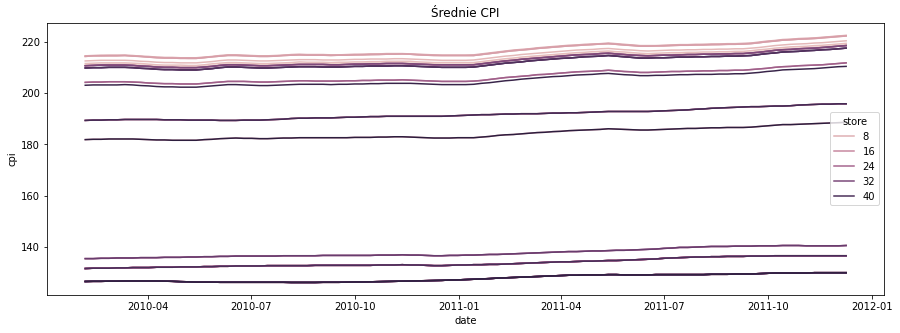

In [22]:
plt.title("Średnie CPI")
sns.lineplot(x='date', y='cpi', hue='store', data=df_features_train);

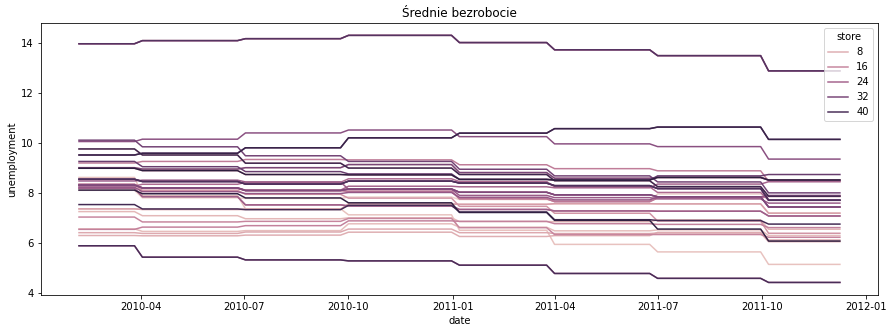

In [23]:
plt.title("Średnie bezrobocie")
sns.lineplot(x='date', y='unemployment', hue='store', data=df_features_train);

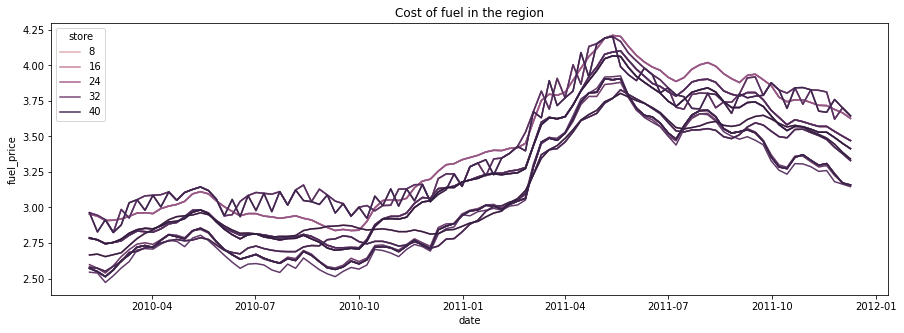

In [24]:
plt.title("Cost of fuel in the region")
sns.lineplot(x='date', y='fuel_price', hue='store', data=df_features_train);

In [25]:
df_features_train.sample(5)

,store,date,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,is_holiday,week
6200,35,2010-04-30,11.968750,2.921875,NaN,NaN,NaN,NaN,NaN,135.875,9.054688,False,17
4797,27,2011-05-06,13.601562,4.191406,NaN,NaN,NaN,NaN,NaN,138.375,7.726562,False,18
2971,17,2011-03-25,2.617188,3.435547,NaN,NaN,NaN,NaN,NaN,128.625,6.867188,False,12
6221,35,2010-09-24,19.484375,2.712891,NaN,NaN,NaN,NaN,NaN,136.625,8.859375,False,38
2033,12,2010-09-10,28.687500,3.044922,NaN,NaN,NaN,NaN,NaN,126.125,14.179688,True,36


In [26]:
df_features_test.sample(5)

,store,date,is_holiday,week
7992,44,2013-04-12,False,15
3221,18,2012-07-13,False,28
5605,31,2012-11-16,False,46
5967,33,2012-11-02,False,44
2323,13,2012-10-05,False,40


### Agregacja dodatkowych cech
#### Temperatura
Cechy mamy per sklep i tydzień

In [27]:
df_temp_agg = df_features_train.groupby(['store', 'week']).agg(['mean'])[['temperature']].reset_index()

In [28]:
df_temp_agg.columns = [' '.join(col).strip() for col in df_temp_agg.columns.values]
df_temp_agg.columns = [col.replace(' ', '_') for col in df_temp_agg.columns.values]

In [29]:
df_temp_agg.sample(3)

,store,week,temperature_mean
1321,26,22,15.265625
280,6,21,26.593750
106,3,3,10.414062


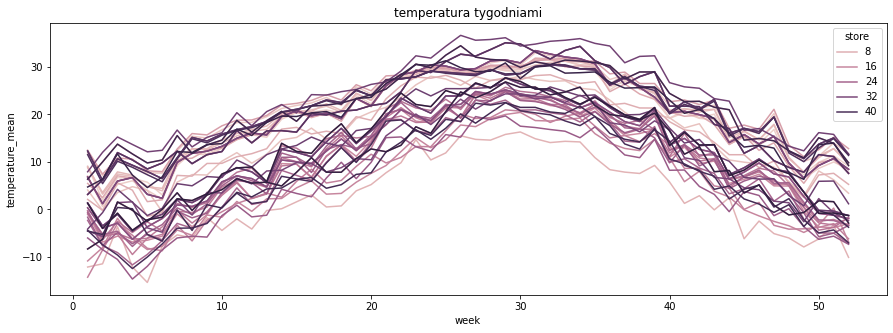

In [30]:
plt.title("temperatura tygodniami")
sns.lineplot(x='week', y='temperature_mean', hue='store', data=df_temp_agg);

In [31]:
df_sales_train = pd.merge(df_sales_train, df_temp_agg, how='left', on=['store', 'week'])
df_sales_test = pd.merge(df_sales_test, df_temp_agg, how='left', on=['store', 'week'])

In [32]:
df_sales_train.sample(3)

,id,weekly_sales,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,store_agg_size,dept_mean,dept_std,dept_median,dept_agg_size,temperature_mean
107599,159455,981.000000,6,48,2010-10-08,False,40,10,21847.619141,23605.909217,13772.780273,6919,1437.535767,1128.615022,1075.000000,95,20.921875
45640,67688,7030.459961,8,17,2011-04-15,False,15,4,13005.255859,14940.574778,7163.450195,6711,7555.977539,1445.781573,7315.430176,97,17.281250
197168,291562,1923.819946,7,85,2011-03-18,False,11,3,8124.029785,10527.368692,4571.474609,6602,2053.523926,756.789205,2007.859985,97,-2.019531


In [33]:
df_sales_test.sample(3)

,id,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,store_agg_size,dept_mean,dept_std,dept_median,dept_agg_size,temperature_mean
47886,147243,36,82,2012-05-18,False,20,5,9346.588867,14157.694817,2053.719971,4191,4726.430176,1105.433398,4492.790039,97.0,23.984375
63533,195607,26,35,2012-01-20,False,3,1,14524.416016,19925.211738,7261.910156,6661,2032.762939,515.595515,1979.839966,97.0,-10.570312
59917,184324,19,92,2012-02-24,False,8,2,20587.753906,24643.559533,12614.765625,6882,113155.351562,10388.534539,112157.109375,97.0,-2.898438


#### Cena paliwa, bezrobocie i CPI
Średnia z okresu czasu. Nie ma sensu patrzeć tygodniami.

In [34]:
# cenę paliwa bierzemy ze średnich z ostatniego roku
ostatni_rok = df_features_train[df_features_train['date'] > pd.to_datetime('2011-10-01')]
df_feat_agg = ostatni_rok.groupby(['store'])[['fuel_price', 'unemployment', 'cpi']].agg(['mean', 'median', 'std']).reset_index()

In [35]:
df_feat_agg.columns = [' '.join(col).strip() for col in df_feat_agg.columns.values]
df_feat_agg.columns = [col.replace(' ', '_') for col in df_feat_agg.columns.values]

In [36]:
df_feat_agg.sample(3)

,store,fuel_price_mean,fuel_price_median,fuel_price_std,unemployment_mean,unemployment_median,unemployment_std,cpi_mean,cpi_median,cpi_std
17,18,3.566406,3.576172,0.050890,8.468750,8.468750,0.0,136.50,136.50,0.000000
24,25,3.523438,3.535156,0.054703,7.082031,7.082031,0.0,211.00,211.00,0.556059
36,37,3.279297,3.291016,0.071490,7.714844,7.714844,0.0,216.75,216.75,0.589845


In [37]:
df_sales_train = pd.merge(df_sales_train, df_feat_agg, how='left', on='store')
df_sales_test = pd.merge(df_sales_test, df_feat_agg, how='left', on='store')

In [38]:
df_sales_train.sample(3)

,id,weekly_sales,store,dept,date,is_holiday,week,month,store_mean,store_std,...,temperature_mean,fuel_price_mean,fuel_price_median,fuel_price_std,unemployment_mean,unemployment_median,unemployment_std,cpi_mean,cpi_median,cpi_std
49785,73724,2416.899902,5,42,2011-05-27,False,21,5,4936.753418,7837.545720,...,26.656250,3.279297,3.291016,0.071490,6.300781,6.300781,0.0,218.500,218.50,0.601070
180603,267072,23058.560547,30,94,2011-03-18,False,11,3,8791.246094,14331.763802,...,14.984375,3.279297,3.291016,0.071490,7.441406,7.441406,0.0,217.625,217.50,0.610811
275247,406920,6280.490234,28,6,2010-03-26,False,12,3,18885.115234,22645.381394,...,14.015625,3.763672,3.808594,0.082798,12.890625,12.890625,0.0,129.750,129.75,0.065881


In [39]:
df_sales_test.sample(3)

,id,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,...,temperature_mean,fuel_price_mean,fuel_price_median,fuel_price_std,unemployment_mean,unemployment_median,unemployment_std,cpi_mean,cpi_median,cpi_std
87860,271371,1,98,2011-12-16,False,50,12,21374.376953,27255.341955,10253.300781,...,9.914062,3.279297,3.291016,0.071490,7.867188,7.867188,0.0,218.00,218.00,0.638602
106522,328905,19,82,2011-12-30,True,52,12,20587.753906,24643.559533,12614.765625,...,-1.861328,3.718750,3.728516,0.046373,7.867188,7.867188,0.0,136.50,136.50,0.000000
128918,398453,10,93,2012-03-23,False,12,3,26363.626953,32963.525168,13780.839844,...,16.281250,3.750000,3.730469,0.079674,7.875000,7.875000,0.0,129.75,129.75,0.065881


### Store - wielkość i typ sklepu

In [40]:
df_store = pd.read_csv("../input/stores_data.csv")
df_store.columns = ["store", "type", "size"]

print(df_store.shape)

(45, 3)


In [41]:
df_store.sample(3)

,store,type,size
13,14,A,200898
12,13,A,219622
19,20,A,203742


In [42]:
# dołączenie danych sklepu do train i test
df_sales_train = pd.merge(df_sales_train, df_store, how='left', left_on='store', right_on='store')
df_sales_test = pd.merge(df_sales_test, df_store, how='left', left_on='store', right_on='store')

df_sales_train.rename(columns={'size': 'store_size'}, inplace=True)
df_sales_test.rename(columns={'size': 'store_size'}, inplace=True)

In [43]:
# mapowanie typu sklepu
type_map = {'A':0, 'B':1, 'C':2}
df_sales_train['type_factorized'] = df_sales_train['type'].map(type_map)
df_sales_test['type_factorized'] = df_sales_test['type'].map(type_map)

---

### Dołączenie danych o sprzedaży z zeszłego roku

In [44]:
df_sales_train['year'] = df_sales_train['date'].dt.isocalendar().year
df_sales_test['year'] = df_sales_test['date'].dt.isocalendar().year

In [45]:
df_sales_train['year_plus_1'] = df_sales_train['year'] + 1

In [46]:
# dołączamy do testu
df_sales_test = pd.merge(df_sales_test, df_sales_train[['year_plus_1', 'week', 'store', 'dept', 'weekly_sales']], 
                         how='left', 
                         left_on=['year', 'week', 'store', 'dept'], 
                         right_on=['year_plus_1', 'week', 'store', 'dept']).rename(columns={'weekly_sales': 'prev_year_sales'})

In [47]:
df_sales_test.sample(3)

,id,store,dept,date,is_holiday,week,month,store_mean,store_std,store_median,...,unemployment_std,cpi_mean,cpi_median,cpi_std,type,store_size,type_factorized,year,year_plus_1,prev_year_sales
67742,209004,23,13,2012-01-27,False,4,1,19643.445312,20998.626321,11950.955078,...,0.0,136.50,136.50,0.000000,B,114533,1,2012,2012,30687.160156
7086,21728,4,87,2012-08-10,False,32,8,28493.947266,33695.399996,14835.009766,...,0.0,129.75,129.75,0.065881,A,205863,0,2012,2012,14763.839844
64056,197201,38,12,2012-05-11,False,19,5,7191.760254,11712.813002,767.640015,...,0.0,129.75,129.75,0.065881,C,39690,2,2012,2012,74.529999


---

## Uczenie

Skalowanie kolumny sales

In [48]:
# usunięcie ujemnej i zerowej sprzedaży
df_sales_train = df_sales_train[df_sales_train['weekly_sales'] > 0]

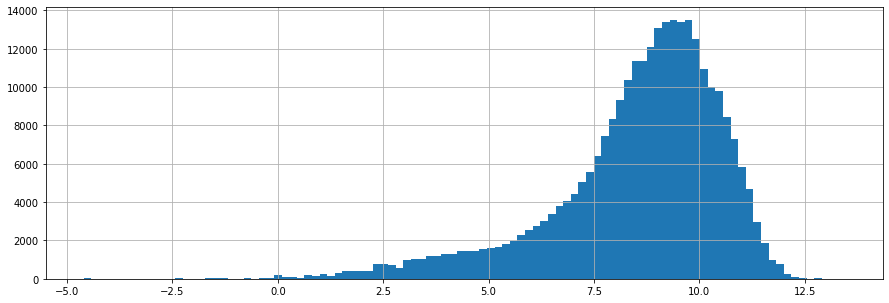

In [49]:
SHIFT = 0
df_sales_train['weekly_sales_log'] = df_sales_train['weekly_sales'].apply(lambda x: np.log(x+SHIFT))
df_sales_train["weekly_sales_log"].hist(bins=100);

In [50]:
list(df_sales_test.columns)

['id',
 'store',
 'dept',
 'date',
 'is_holiday',
 'week',
 'month',
 'store_mean',
 'store_std',
 'store_median',
 'store_agg_size',
 'dept_mean',
 'dept_std',
 'dept_median',
 'dept_agg_size',
 'temperature_mean',
 'fuel_price_mean',
 'fuel_price_median',
 'fuel_price_std',
 'unemployment_mean',
 'unemployment_median',
 'unemployment_std',
 'cpi_mean',
 'cpi_median',
 'cpi_std',
 'type',
 'store_size',
 'type_factorized',
 'year',
 'year_plus_1',
 'prev_year_sales']

In [51]:
cechy_do_uczenia = [
    'store', 'dept', 'is_holiday', 'week', 'month',
    'store_mean',
    'store_std',
    'store_median',
    'store_agg_size',
    'dept_mean',
    'dept_std',
    'dept_median',
    'dept_agg_size',
    'temperature_mean', 
    'fuel_price_mean',
    'fuel_price_median',
    'fuel_price_std',
    'unemployment_mean',
    'unemployment_median',
    'unemployment_std',
    'cpi_mean',
    'cpi_median',
    'cpi_std',
    'store_size', 
    'type_factorized',
]

In [52]:
# własna funkcja straty dla xgboost
def fair_obj(y_true, preds):
    labels = y_true  # .get_labels()
    x = preds - labels
    c = 0.7
    den = abs(x) + c
    grad = c*x / (den)
    hess = c*c / den*den
    return grad, hess

In [53]:
def mae_log_eval(y_log_pred, dtrain):
    y_log_true = dtrain.get_label()
    shift = SHIFT
    y_true = np.exp(y_log_true) - shift
    y_pred = np.exp(y_log_pred) - shift
    return 'mae', mean_absolute_error(y_true, y_pred)

In [54]:
def testuj_model(X, y, model, cv=3):
    # UWAGA: dla timeseries nie należy walidować danych w ten sposób !!!
    # W ten sposób do walidacji przeszłych punktów używamy przyszłych danych.
    cv = KFold(n_splits=cv, shuffle=True, random_state=42)

    scores = []

    for train_idx, test_idx in cv.split(X):
        X_train_cv, X_test_cv = X[train_idx], X[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]

        eval_set = [(X_train_cv, y_train_cv),
                    (X_test_cv, y_test_cv)]

        model.fit(X_train_cv, y_train_cv, eval_metric=mae_log_eval,
                  eval_set=eval_set,
                  verbose=10)

        y_pred = model.predict(X_test_cv)
        y_pred_fin = np.exp(y_pred) - SHIFT
        y_test_fin = np.exp(y_test_cv) - SHIFT
        error = mean_absolute_error(y_test_fin, y_pred_fin)
        print(f'Mean absolute error: {error:.5f}')
        scores.append(error)

    print('Model:')
    print(model)
    print(f'Średni błąd:\t{np.mean(scores):.05f}')
    print(f'StdDev błąd:\t{np.std(scores):.05f}')

    return np.mean(scores)

In [55]:
X_train = df_sales_train[cechy_do_uczenia].values
X_test = df_sales_test[cechy_do_uczenia].values

y_train = df_sales_train['weekly_sales_log'].values

In [56]:
# moje szczęśliwe parametry, z braku czasu skopiowane z jakiegoś innego modelu. Noe były optymalizowane an tym modelu
xgb_params ={
    'objective': fair_obj,
    'max_depth': 14,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'min_child_weight': 3.0,
    'reg_alpha': 1.010560518922879,
    'reg_lambda': 0.9990634429213564,
    'subsample': 0.9669849576928992,
    'random_state': 0
}

In [57]:
model = xgb.XGBRegressor(**xgb_params)

In [58]:
testuj_model(X_train, y_train, model)

[0]	validation_0-rmse:8.16031	validation_0-mae:16013.47559	validation_1-rmse:8.15454	validation_1-mae:16039.26269
[10]	validation_0-rmse:6.90549	validation_0-mae:16008.57422	validation_1-rmse:6.90021	validation_1-mae:16034.36621
[20]	validation_0-rmse:5.68754	validation_0-mae:15991.49414	validation_1-rmse:5.68312	validation_1-mae:16017.30664
[30]	validation_0-rmse:4.51820	validation_0-mae:15933.87793	validation_1-rmse:4.51513	validation_1-mae:15959.79199
[40]	validation_0-rmse:3.41609	validation_0-mae:15749.04199	validation_1-rmse:3.41528	validation_1-mae:15775.40332
[50]	validation_0-rmse:2.41106	validation_0-mae:15203.75098	validation_1-rmse:2.41396	validation_1-mae:15231.69629
[60]	validation_0-rmse:1.54999	validation_0-mae:13796.97461	validation_1-rmse:1.55938	validation_1-mae:13830.25586
[70]	validation_0-rmse:0.89776	validation_0-mae:10899.41309	validation_1-rmse:0.91909	validation_1-mae:10946.51758
[80]	validation_0-rmse:0.51864	validation_0-mae:6761.00732	validation_1-rmse:0.56

1416.1695339653131

In [59]:
model_final = xgb.XGBRegressor(**xgb_params)
model_final.fit(X_train, y_train, eval_metric=mae_log_eval, verbose=10)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=14, min_child_weight=3.0, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=4,
             num_parallel_tree=1,
             objective=<function fair_obj at 0x000001AE9B815820>,
             predictor='auto', random_state=0, reg_alpha=1.010560518922879,
             reg_lambda=0.9990634429213564, scale_pos_weight=1,
             subsample=0.9669849576928992, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [60]:
y_pred = model_final.predict(X_test)

In [61]:
df_sales_test["weekly_sales"] = np.exp(y_pred)

In [62]:
df_sales_test['weekly_sales_mean'] = df_sales_test.apply(lambda row: np.nanmean([row['weekly_sales'], row['prev_year_sales']]), axis=1)

In [63]:
df_sales_test[['id', 'weekly_sales_mean']].to_csv(r'../output/test_xgb_log_with_stats_plus_prev_year.csv', index=False)